# Proposito del proyecto

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Para llevar a cabo esta evaluación tendremos en cuenta que:
- Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol
- Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto

La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas, para lo cual necesitaremos:
- Construir y evaluar modelos de redes neuronales con arquitectura ResNet50 .
- Evaluar los modelos con la métrica EAM, esta debe ser inferior a 7.


## Inicialización

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import inspect

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Crearemos un generador con ImageDataGenerator.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [7]:
labels.duplicated().sum()

0

In [8]:
features, target = next(train_gen_flow)
print(f' Tamaño de las características/imagenes: {features.shape}')
print(f' Tamaño del objetivo: {target.shape}')

 Tamaño de las características/imagenes: (32, 224, 224, 3)
 Tamaño del objetivo: (32,)


Observamos que nuestro dataset presenta:
- Un total de 7591 imágenes de tamaño 2224x224x3.  
- Se escogió una muestra de 32 imágenes.
- No presenta valores nulos, valores duplicados, y los tipos de datos estan correctos.

## EDA

Para nuestra exploración de distribución de datos emplearemos un gráfico de barras y un diagrame de cajas para la edad, y en cuanto a las imágenes, escogeremos una submuestra, las imprimiremos y las analizaremos.

In [9]:
#Observmos la distribución de los datos
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


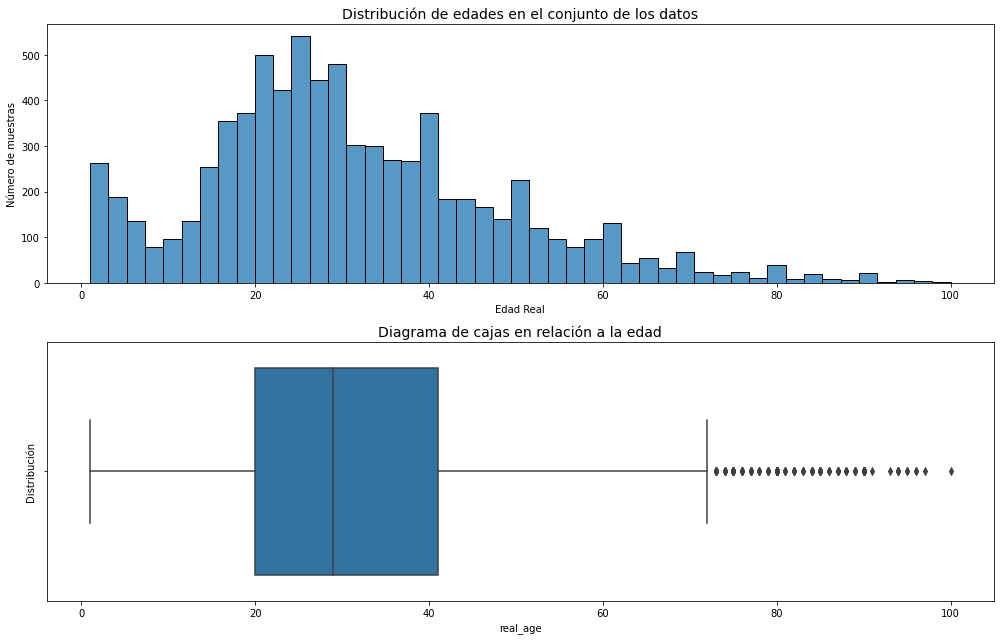

In [10]:
#Generamos subplots para la visualización de datos
fig, axs = plt.subplots(2, 1, figsize=(14, 9))

#Trazamos el gráfico de barras
ax1 = axs[0]
sns.histplot(data=labels, x='real_age', ax=ax1)
ax1.set_title('Distribución de edades en el conjunto de los datos', fontsize=14)
ax1.set_xlabel('Edad Real')
ax1.set_ylabel('Número de muestras')

#Trazamos el boxplot
ax2 = axs[1]
sns.boxplot(data=labels, x='real_age', ax=ax2)
ax2.set_title('Diagrama de cajas en relación a la edad', fontsize=14)
ax2.set_ylabel('Distribución')

fig.tight_layout()

Obtuvimos de nuestro describe que las edades tienen un rango de 1-100 años. Con una media de 31 años y una mediana de 29 años. Observamos una asimetría positiva (sesgo a la derecha) en nuestro gráfico de barras con una concentración en el rando de 20-40 años de edad. En nuestro diagrama de caja podemos ver claramente esta concentración. Entre los valores atípicos vemos que estan denotados como mayores de 70 años, pero estos datos son todos necesarios por lo cual los convervaremos.

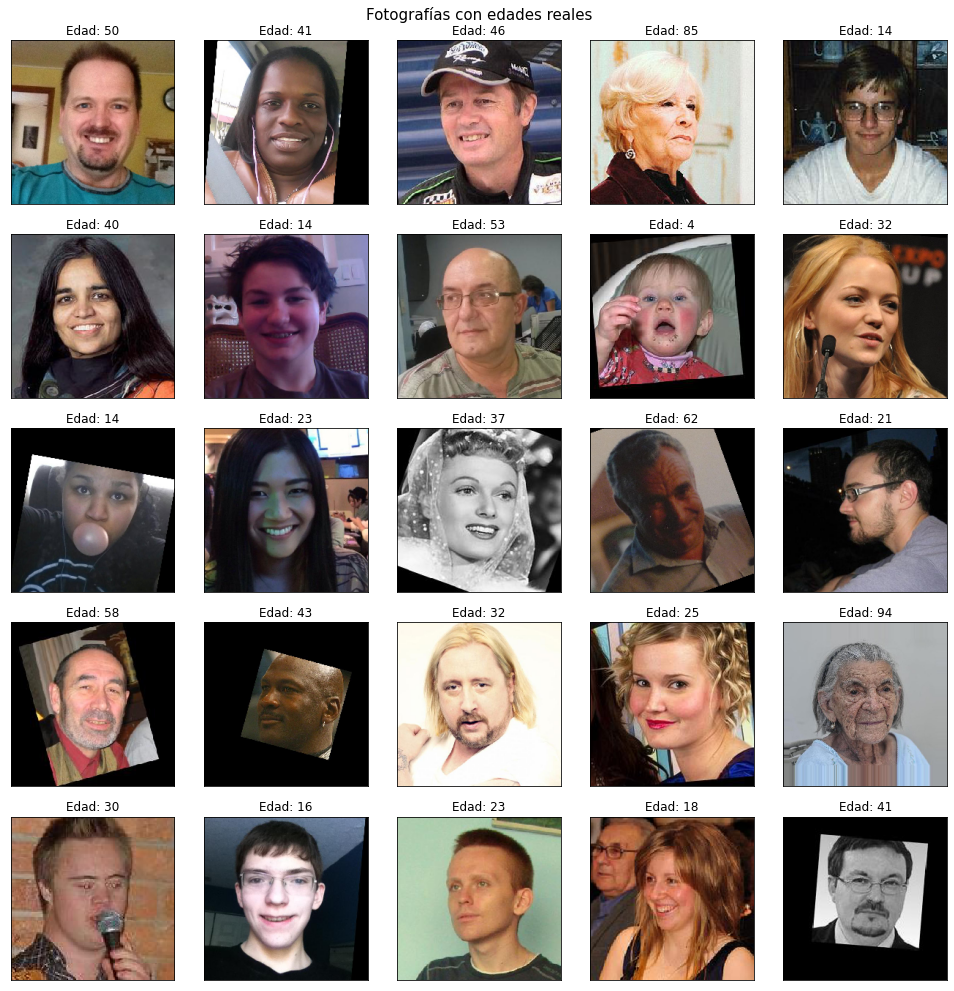

In [11]:
fig = plt.figure(figsize=(14, 14))
for i in range(25):
    fig.add_subplot(5 ,5 , i+1)
    plt.imshow(features[i])
    plt.title(f'Edad: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Fotografías con edades reales', fontsize=15)
    plt.tight_layout()

Observamos que nuestra muestra de imágenes tiene un rango de edad de 4 a 94 años de edad, 9 de ellos estan dentro de nuestro grupo con mayor concentración. Observamos que varias de las imágenes están enmarcando el rostro y de frente, lo que es bueno para nuestro estudio, pero también se obsevan:

- Objetos que interfieren con el rostro.
- Imágenes no enmarcadas en el rostro.
- Ruido de fondo.
- Imágenes con inclinaciones.
- Rostros con lentes.
- Rostros de perfil.

Todas estas características podrían interferir con la detección de edades.

### Conclusiones

- Obtuvimos que nuestro dataset tiene un rango de edades de 1-100 años.
- Presentó una concentración de imágenes con edades de 20-40 años. Los imágenes de adultos mayores son la minoría.
- Observamos que hay características que pueden interferir con las predicciones de las edades por lo cual aplicaremos diferentes aumentos que puedan mitigar este problema (rotación, aumento vertical y horizontal).

## Modelado

Definiremos cuatro funciones que facilitaran el procesamiento de los diferentes modelos en la plataforma GPU:
- ***load_train y load_test :*** Cargará los conjuntos de entrenamiento y de prueba respectivamente, mediante la clase de ImageDataGenerator. En una proporción 75:25.


- ***create_model :*** Definirá los modelos a evaluar, para nuestro proyecto usaremos redes neuronales convolucionales ResNet50, que tendrá 50 capas de profundidad, en conjunto con un salto que pasa por alto 2 capas sucesivas a gran escala, de esta manera la red aprende de forma representativa las características de las imágenes. Se definirán las funciones para aceptar imágenes de 224x224. Nuestro modelo es de regresión (ya que busca predecir la edad), por lo tanto en la capa de salida solo tendremos una sola capa con la activación 'relu'. La métrica de perdida que se aplicará a nuestro modelo será el error medio absoluto 'mae' que a su vez estará optimizada por el algoritmo 'adam' con una taza de aprendizaje de '0.0001'. 


- ***train_model :*** En esta función entrenaremos y evaluaremos el modelo a través de 20 epocas.

Los modelos a evaluar serán los siguientes:

- ***Modelo 1:*** Este modelo solo presentara capas ResNet50, una capa de GlobalAveragePooling y una capa de salida con una neurona.


- ***Modelo 2:*** Este modelo presentara capas ResNet50, una capa GlobalAveragePooling, dos capas Dropout de 0.20, y una capa de salida con una neurona. Este modelo presentará el aumento: horizontal_flip.


- ***Modelo 3:*** Este modelo presentara capas ResNet50, una capa GlobalAvergaPooling, una capa Dropout 0.20, y una capa de salidad con una neurona. Este modelo presentará los siguientes aumentos: 
    - horizontal_flip, shear_range, zoom_range, height_shift_range, width_shift_range, rotation_range. 

Observamos las funciones con los hiperparámetros de los modelos 2 y 3 comentados

In [12]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels = pd.read_csv(path+'labels.csv')
    
    
    #Modelo 1 
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale= 1.0 / 255)
    
    #Modelo 2 
    #train_datagen = ImageDataGenerator(validation_split=0.25,
    #                                  rescale= 1.0 / 255,
    #                                 horizontal_flip = True)
    #Modelo 3
    #train_datagen = ImageDataGenerator(validation_split=0.25,
    #                                   rescale= 1.0 / 255,
    #                                   horizontal_flip = True
    #                                   shear_range=0.2,
    #                                   zoom_range= 0.2,
    #                                   height_shift_range= 0.1,
    #                                   width_shift_range= 0.1,
    #                                   rotation_range= 15)
    
    
    train_gen_flow = train_datagen.flow_from_data_frame(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size= (224,224),
        batch_size= 32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [13]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split= 0.25,
                                      rescale = 1.0/255)
    
    test_gen_flow = test_datagen.flow_from_data_frame(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size= (224,224),
        batch_size= 32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    

    return test_gen_flow

In [14]:
def create_model(input_shape=(224,224,3)):
    
    """
    Define el modelo
    """
    
    backbone = ResNet50(
    input_shape=input_shape, weights=imagenet, include_top=False)
    
    #Modelo 1
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
              
    #Modelo 2
    #model = Sequential()
    #model.add(backbone)
    #model.add(Dropout(0.20))
    #model.add(GlobalAveragePooling2D()
    #model.add(Dropout(0.20))
    #model.add(Dense(1, activation='relu'))

    #Modelo 3
    #model = Sequential()
    #model.add(backbone)
    #model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.20))
    #model.add(Dense(1, activation='relu'))
              
    optimizer= Adam(learning_rate= 0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics= ['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
              

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Nuestros modelos fueron procesados en una plataforma GPU para que el tiempo de entrenamiento sea menor. Mostraremos el script utilizado en el modelo 3.

In [16]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """

import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import inspect
"""

#Descargamos el script con formato py para procesarlo en GPU
with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

#### Modelo 1

Train for 178 steps, validate for 60 steps

Epoch 1/20
178/178 - 59s - loss: 237.3159 - mae: 11.0539 - val_loss: 790.5224 - val_mae: 23.1916

Epoch 2/20
178/178 - 39s - loss: 62.9803 - mae: 6.0014 - val_loss: 670.5533 - val_mae: 20.7934

Epoch 3/20
178/178 - 39s - loss: 29.6773 - mae: 4.2034 - val_loss: 266.1292 - val_mae: 12.1844

Epoch 4/20
178/178 - 39s - loss: 19.1345 - mae: 3.3768 - val_loss: 145.3935 - val_mae: 8.9690

Epoch 5/20
178/178 - 39s - loss: 15.4367 - mae: 3.0461 - val_loss: 83.6790 - val_mae: 6.9945

Epoch 6/20
178/178 - 39s - loss: 12.6484 - mae: 2.7519 - val_loss: 67.7430 - val_mae: 6.2871

Epoch 7/20
178/178 - 39s - loss: 10.4685 - mae: 2.4956 - val_loss: 69.0909 - val_mae: 6.3793

Epoch 8/20
178/178 - 40s - loss: 8.5962 - mae: 2.2470 - val_loss: 68.8384 - val_mae: 6.2724

Epoch 9/20
178/178 - 39s - loss: 8.1592 - mae: 2.1376 - val_loss: 68.9555 - val_mae: 6.2672

Epoch 10/20
178/178 - 39s - loss: 7.3422 - mae: 2.0427 - val_loss: 67.9887 - val_mae: 6.2706

Epoch 11/20
178/178 - 39s - loss: 6.2990 - mae: 1.8992 - val_loss: 67.8659 - val_mae: 6.3573

Epoch 12/20
178/178 - 39s - loss: 5.7257 - mae: 1.7979 - val_loss: 68.3880 - val_mae: 6.3494

Epoch 13/20
178/178 - 39s - loss: 5.8030 - mae: 1.8001 - val_loss: 67.6054 - val_mae: 6.1791

Epoch 14/20
178/178 - 39s - loss: 5.8781 - mae: 1.8142 - val_loss: 67.4243 - val_mae: 6.2453

Epoch 15/20
178/178 - 40s - loss: 5.6584 - mae: 1.7865 - val_loss: 69.5611 - val_mae: 6.5353

Epoch 16/20
178/178 - 40s - loss: 5.7979 - mae: 1.8182 - val_loss: 63.3093 - val_mae: 6.0184

Epoch 17/20
178/178 - 39s - loss: 5.3970 - mae: 1.7666 - val_loss: 65.7856 - val_mae: 6.1864

Epoch 18/20
178/178 - 39s - loss: 4.6217 - mae: 1.6191 - val_loss: 65.3962 - val_mae: 6.1450

Epoch 19/20
178/178 - 39s - loss: 4.9256 - mae: 1.6651 - val_loss: 63.6894 - val_mae: 6.0926

Epoch 20/20
178/178 - 40s - loss: 4.8585 - mae: 1.6598 - val_loss: 63.1670 - val_mae: 6.0313

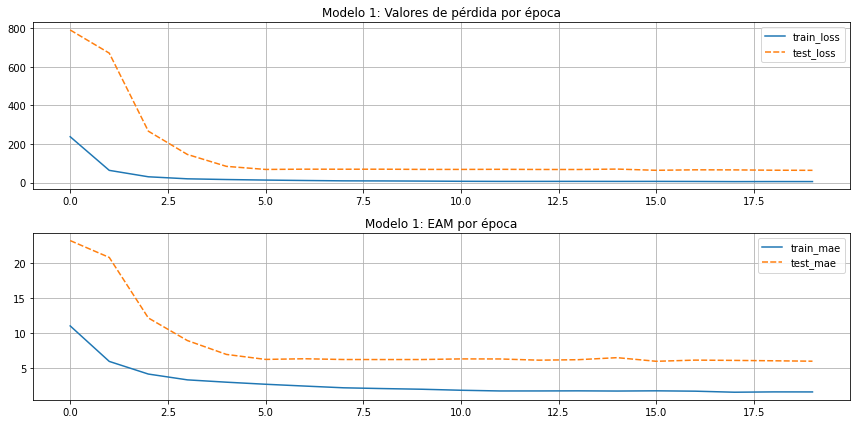

In [17]:
model_1 = pd.DataFrame(
    {'train_loss': [237.3159, 62.9803, 29.6773, 19.1345, 15.4367, 12.6484, 10.4685, 8.5962, 8.1592, 7.3422, 
                   6.2990, 5.7257, 5.8030, 5.8781, 5.6584, 5.7979, 5.3970, 4.6217, 4.9256, 4.8585],
     'train_mae': [11.0539, 6.0014, 4.2034, 3.3768, 3.0461, 2.7519, 2.4956, 2.2470, 2.1376, 2.0427,
                  1.8992, 1.7979, 1.8001, 1.8142, 1.7865, 1.8182, 1.7666, 1.6191, 1.6651, 1.6598],
     'test_loss': [790.5224, 670.5533, 266.1292, 145.3935, 83.6790, 67.7430, 69.0909, 68.8384, 68.9555, 67.9887,
                  67.8659, 68.3880, 67.6054, 67.4243, 69.5611, 63.3093, 65.7856, 65.3962, 63.6894, 63.1670],
     'test_mae': [23.1916, 20.7934, 12.1844, 8.9690, 6.9945, 6.2871, 6.3793, 6.2724, 6.2672, 6.2706,
                 6.3573, 6.3494, 6.1791, 6.2453, 6.5353, 6.0184, 6.1864, 6.1450, 6.0926, 6.0313]})
    
fig, axs = plt.subplots(2,1, figsize=(12,6))

ax1=axs[0]
sns.lineplot(data=model_1[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Modelo 1: Valores de pérdida por época')
ax1.grid(True)

ax2=axs[1]
sns.lineplot(data=model_1[['train_mae', 'test_mae']], ax=ax2)
ax2.set_title('Modelo 1: EAM por época')
ax2.grid(True)

plt.tight_layout()
plt.show()

El valor EAM alcanzado por nuestro modelo 1 fué de 6.03 en el conjunto de validación, y de 1.66 en el conjunto de entrenamiento, lo que muestra un fuerte sobreajuste de más de cuatro puntos, esto puede relacionarse a que las redes neuronales con grandes cantidades de capas tienden a sobreajustarse.

#### Modelo 2

Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 55s - loss: 263.7834 - mae: 11.6060 - val_loss: 566.3178 - val_mae: 18.7515

Epoch 2/20
178/178 - 38s - loss: 83.6498 - mae: 6.9028 - val_loss: 504.7612 - val_mae: 17.1454

Epoch 3/20
178/178 - 38s - loss: 55.3190 - mae: 5.5944 - val_loss: 249.5360 - val_mae: 12.1645

Epoch 4/20
178/178 - 38s - loss: 37.3767 - mae: 4.6843 - val_loss: 111.2661 - val_mae: 7.9679

Epoch 5/20
178/178 - 38s - loss: 28.2097 - mae: 4.0663 - val_loss: 95.3455 - val_mae: 7.3449

Epoch 6/20
178/178 - 38s - loss: 23.1003 - mae: 3.6882 - val_loss: 101.5460 - val_mae: 7.9598

Epoch 7/20
178/178 - 38s - loss: 20.5453 - mae: 3.4500 - val_loss: 69.3291 - val_mae: 6.3762

Epoch 8/20
178/178 - 38s - loss: 17.5153 - mae: 3.2300 - val_loss: 63.7860 - val_mae: 5.9636

Epoch 9/20
178/178 - 38s - loss: 15.9554 - mae: 3.0719 - val_loss: 73.3573 - val_mae: 6.3463

Epoch 10/20
178/178 - 38s - loss: 12.5064 - mae: 2.6774 - val_loss: 62.3426 - val_mae: 5.9402

Epoch 11/20
178/178 - 38s - loss: 11.0264 - mae: 2.5487 - val_loss: 79.7116 - val_mae: 6.9951

Epoch 12/20
178/178 - 38s - loss: 10.4793 - mae: 2.4624 - val_loss: 72.9773 - val_mae: 6.2837

Epoch 13/20
178/178 - 38s - loss: 9.9595 - mae: 2.3862 - val_loss: 58.7050 - val_mae: 5.7914

Epoch 14/20
178/178 - 38s - loss: 9.0890 - mae: 2.2888 - val_loss: 62.3044 - val_mae: 5.9078

Epoch 15/20
178/178 - 38s - loss: 8.5679 - mae: 2.2174 - val_loss: 61.7149 - val_mae: 5.8900

Epoch 16/20
178/178 - 38s - loss: 8.1139 - mae: 2.1285 - val_loss: 63.4835 - val_mae: 5.9456

Epoch 17/20
178/178 - 38s - loss: 8.2169 - mae: 2.1722 - val_loss: 76.6751 - val_mae: 6.4723

Epoch 18/20
178/178 - 38s - loss: 8.3081 - mae: 2.1801 - val_loss: 65.5255 - val_mae: 6.1500

Epoch 19/20
178/178 - 38s - loss: 8.3704 - mae: 2.1753 - val_loss: 68.2867 - val_mae: 6.1627

Epoch 20/20
178/178 - 38s - loss: 8.4658 - mae: 2.1767 - val_loss: 60.4499 - val_mae: 5.8466


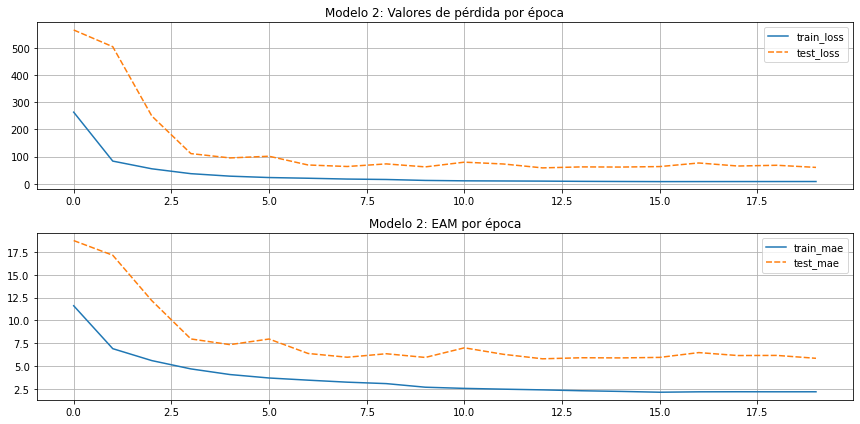

In [18]:
model_2 = pd.DataFrame(
    {'train_loss': [263.7834, 83.6498, 55.3190, 37.3767, 28.2097, 23.1003, 20.5453, 17.5153, 15.9554, 12.5064,
                    11.0264, 10.4793, 9.9595, 9.0890, 8.5679, 8.1139, 8.2169, 8.3081, 8.3704, 8.4658],
     'train_mae': [11.6060, 6.9028, 5.5944, 4.6843, 4.0663, 3.6882, 3.4500, 3.2300, 3.0719, 2.6774,
                   2.5487, 2.4624, 2.3862, 2.2888, 2.2174, 2.1285, 2.1722, 2.1801, 2.1753, 2.1767],
     'test_loss': [566.3178, 504.7612, 249.5360, 111.2661, 95.3455, 101.5460, 69.3291, 63.7860, 73.3573, 62.3426,
                   79.7116, 72.9773, 58.7050, 62.3044, 61.7149, 63.4835, 76.6751, 65.5255, 68.2867, 60.4499],
     'test_mae': [18.7515, 17.1454, 12.1645, 7.9679, 7.3449, 7.9598, 6.3762, 5.9636, 6.3463, 5.9402,
                  6.9951, 6.2837, 5.7914, 5.9078, 5.8900, 5.9456, 6.4723, 6.1500, 6.1627, 5.8466]})

# Crear gráficos
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax1 = axs[0]
sns.lineplot(data=model_2[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Modelo 2: Valores de pérdida por época')
ax1.grid(True)

ax2 = axs[1]
sns.lineplot(data=model_2[['train_mae', 'test_mae']], ax=ax2)
ax2.set_title('Modelo 2: EAM por época')
ax2.grid(True)

plt.tight_layout()
plt.show()

El valor EAM alcanzado por nuestro modelo 2 fué de 5.84 para el conjunto de validación y de 2.17 en el conjunto de entrenamiento. Observamos en nuestro modelo que el sobreajuste mejoró en comparación con el modelo 1 que no contaba con una capa Dropout, y que al incluir un aumento mejoró la métrica de EAM.

#### Modelo 3

Train for 178 steps, validate for 60 steps

Epoch 1/20
178/178 - 107s - loss: 327.4757 - mae: 13.0216 - val_loss: 475.1674 - val_mae: 16.7162

Epoch 2/20
178/178 - 93s - loss: 104.4556 - mae: 7.7049 - val_loss: 465.3547 - val_mae: 16.3756

Epoch 3/20
178/178 - 93s - loss: 83.9363 - mae: 6.9612 - val_loss: 357.4626 - val_mae: 14.6383

Epoch 4/20
178/178 - 93s - loss: 72.5918 - mae: 6.4764 - val_loss: 137.3574 - val_mae: 8.4465

Epoch 5/20
178/178 - 93s - loss: 59.9245 - mae: 5.9209 - val_loss: 119.5885 - val_mae: 8.2619

Epoch 6/20
178/178 - 93s - loss: 49.8788 - mae: 5.4387 - val_loss: 106.4523 - val_mae: 7.5885

Epoch 7/20
178/178 - 93s - loss: 44.7611 - mae: 5.1408 - val_loss: 83.8669 - val_mae: 6.6775

Epoch 8/20
178/178 - 93s - loss: 39.4463 - mae: 4.8209 - val_loss: 88.9494 - val_mae: 6.9185

Epoch 9/20
178/178 - 93s - loss: 37.9832 - mae: 4.7555 - val_loss: 94.9610 - val_mae: 6.9792

Epoch 10/20
178/178 - 93s - loss: 33.4968 - mae: 4.4669 - val_loss: 83.2320 - val_mae: 6.9093

Epoch 11/20
178/178 - 93s - loss: 29.2794 - mae: 4.2068 - val_loss: 76.1008 - val_mae: 6.5013

Epoch 12/20
178/178 - 93s - loss: 26.7574 - mae: 3.9852 - val_loss: 70.2856 - val_mae: 6.2022

Epoch 13/20
178/178 - 93s - loss: 29.2902 - mae: 4.1475 - val_loss: 78.2171 - val_mae: 6.5564

Epoch 14/20
178/178 - 93s - loss: 22.4126 - mae: 3.6617 - val_loss: 74.3129 - val_mae: 6.4863

Epoch 15/20
178/178 - 93s - loss: 23.1954 - mae: 3.7301 - val_loss: 64.9641 - val_mae: 6.1163

Epoch 16/20
178/178 - 94s - loss: 20.4049 - mae: 3.4583 - val_loss: 75.3193 - val_mae: 6.3742

Epoch 17/20
178/178 - 96s - loss: 18.6513 - mae: 3.3572 - val_loss: 96.0445 - val_mae: 7.4595

Epoch 18/20
178/178 - 97s - loss: 18.3470 - mae: 3.3088 - val_loss: 81.5808 - val_mae: 6.5282

Epoch 19/20
178/178 - 93s - loss: 16.7509 - mae: 3.1656 - val_loss: 68.2502 - val_mae: 6.1855

Epoch 20/20
178/178 - 99s - loss: 18.1009 - mae: 3.2604 - val_loss: 67.4004 - val_mae: 6.1099

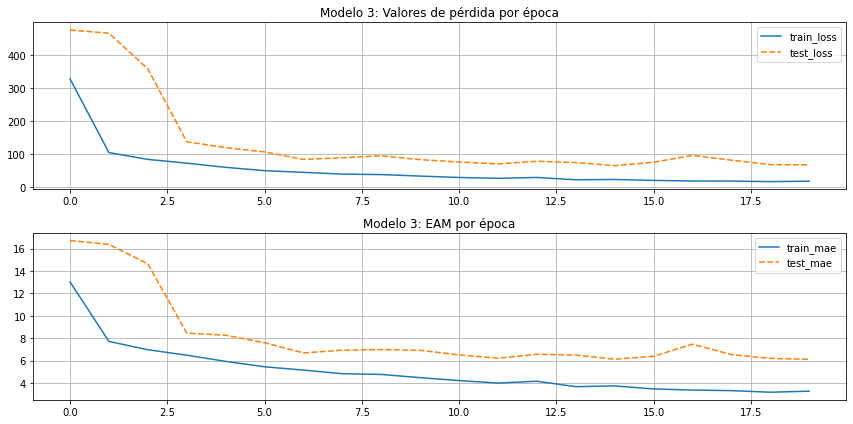

In [19]:
model_3 = pd.DataFrame(
    {'train_loss': [327.4757, 104.4556, 83.9363, 72.5918, 59.9245, 49.8788, 44.7611, 39.4463, 37.9832, 33.4968,
                   29.2794, 26.7574, 29.2902, 22.4126, 23.1954, 20.4049, 18.6513, 18.3470, 16.7509, 18.1009],
     'train_mae': [13.0216, 7.7049, 6.9612, 6.4764, 5.9209, 5.4387, 5.1408, 4.8209, 4.7555, 4.4669,
                  4.2068, 3.9852, 4.1475, 3.6617, 3.7301, 3.4583, 3.3572, 3.3088, 3.1656, 3.2604],
     'test_loss': [475.1674, 465.3547, 357.4626, 137.3574, 119.5885, 106.4523, 83.8669, 88.9494, 94.9610, 83.2320,
                  76.1008, 70.2856, 78.2171, 74.3129, 64.9641, 75.3193, 96.0445, 81.5808, 68.2502, 67.4004],
     'test_mae': [16.7162, 16.3756, 14.6383, 8.4465, 8.2619, 7.5885, 6.6775, 6.9185, 6.9792, 6.9093,
                 6.5013, 6.2022, 6.5564, 6.4863, 6.1163, 6.3742, 7.4595, 6.5282, 6.1855, 6.1099]})

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax1 = axs[0]
sns.lineplot(data=model_3[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Modelo 3: Valores de pérdida por época')
ax1.grid(True)

ax2 = axs[1]
sns.lineplot(data=model_3[['train_mae', 'test_mae']], ax=ax2)
ax2.set_title('Modelo 3: EAM por época')
ax2.grid(True)

plt.tight_layout()
plt.show()

El valor EAM alcanzado por nuestro modelo 3 fué de 6.10 para el conjunto de validación y de 3.26 para el conjunto de entrenamiento, observamos que el sobreajuste ha disminuido considerablemente debido a los aumentos y a los saltos, pero la métrica no muestra mejora sino que muestra un ligero incremento en las ultimas épocas. Podriamos decir que el utilizar muchos aumentos altera la calidad del modelo. 

## Conclusiones

- Se trabajó con un total de 7591 imágenes de tamaño 2224x224x3 que contenían los rostros de personas. Se escogió una muestra de 32 imágenes. Nuestro dataset no presentó valores nulos, valores duplicados, y los tipos de datos estaban correctos.
- Se aplicaron gráficos de barras y diagramas de cajas para observar la distribución de nuestros datos, obtuvimos que nuestro dataset tiene un rango de edades de 1-100 años el cual presentó una concentración de imágenes con edades de 20-40 años. Los imágenes de adultos mayores son la minoría.
- Se imprimieron 25 fotografías de una muestra de 32, las cuales se importaron con la clase ImageDataGenerator, en ellas observamos que hay características que podrían interferir con las predicciones de las edades por lo cual se decidió aplicar diferentes aumentos entre los modelos para que pudieran mitigar este problema (rotación, aumento vertical y horizontal).
- Construimos 3 modelos con arquitectura ResNet, estos presentaron una capa de salida con activación 'relu', también presentaron optimización con el algoritmo 'adam' con una tasa de aprendizaje de '0.0001'. La métrica de evalución fue el EAM. Concluimos de nuestros modelos.
- **Mejor modelo:** El modelo 2 presentó el mejor valor EAM, con 5.84 en el conjunto de validación, este modelo presento un solo aumento y dos capas Dropout,  seguido del modelo 1 con un EAM de 6.03, sin aumentos y sin capas Dropout, este modelo presento el mayor sobreajuste, el modeo 3 presento un EAM de 6.10, este modelo con 6 aumentos y una sola capa Dropout, tuvo el EAM mas alto, pero fue el que menos sobreajuste presento. 
- Concluimos que establecer aumentos es importante para que los modelos de redes neuronales puedan contar con más información que mejore la capacidad de detección de edades, pero es necesario no exceder el número de aumentos ya que se crearían imágenes diferentes a las originales y esto afectaría el rendimiento del modelo, tambien encontramos que incluir capas Dropout permite que el modelo no se sobreajuste.